# Steinberg-Style Analysis

This notebook will be used to replicate some of the methods and plots from [[Steinberg 2022]] using argo data. To see a list of applicable tasks and other useful notes, see: https://github.com/ocean-transport/argo-intern/issues/10#issuecomment-1574128413 

In [1]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload
from cmocean import cm as cmo
import xrft
import pandas as pd


import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf

In [2]:
reload(df)
reload(ef)
reload(ff)
reload(pf);

In [3]:
float_z = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_z.nc')
float_r = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_rho.nc')

## Figure 3

I'd like to make this plot (or at least parts a/b and e/f) because I think it's visually useful to frame what density surfaces look like in a given region, however I haven't solved the profile identification issue from the methods notebook, so I think it's best to put this plot on hold for now. If the MLD .nc file is more of a pain than it's worth, I can also calculate MLD using threshold values at least.

Ultimately, this is probably a rabbit hole that might not be that important to chase down right now. Move forward with something you know you can do.

## Figure 5

This plot shows variance at different locations, filter scales, and seasons and we would additionally need it to displace these metrics across depths. That's a lot of information floating out there. I think it makes sense to only focus on one region and figure out how to show variance at different scales, seasons, and depths at that specific location. Then expand the geography when you're more comfortable

To make this plot, you will first need to calculate EV at different scales, which Steinberg has a framework for. I will use the following scales:
- l0 = 400m
- l1 = 200m
- l2 = 100m

So the analysis will take the following form:

$$ prof_{l0} = (f^{400})^2 $$

$$ prof_{l1} = (f^{200})^2 - (f^{400))^2 $$

$$ prof_{l2} = (f^{100})^2 - (f^{200))^2 $$

$$ prof_{l1} = (f)^2 - (f^{100))^2 $$

In [47]:
l0 = 400
l1 = 200
l2 = 100

In [67]:
prof_l0 = ef.get_MV(float_z,l0,variable='SPICE')
prof_l1 = ef.get_MV(float_z,l1) - ef.get_MV(float_z,l0,variable='SPICE')
prof_l2 = ef.get_MV(float_z,l2) - ef.get_MV(float_z,l1,variable='SPICE')
prof_lf = float_z.SPICE**2      - ef.get_MV(float_z,l2,variable='SPICE')

Need a function that adds a month coordinate to xarray, it's annoying to have to type ".TIME.dt.month" every time. 

Now that I've made the one below, I'm considering I don't want an integer value of 0-12 because I need a smooth curve that runs from January to December. Instead, I need something that is fractional month (to progressively move along the x axis) and this should reorder the DataArray so the sequence is strictly increasing.

In [68]:
def add_month(ds, variable='TIME'):
    copy = ds
    copy['frac_day']   = (copy['TIME'] - pd.to_datetime(copy['TIME'].dt.date)).dt.seconds / (24 * 3600)
    copy['frac_month'] = (copy['TIME'].dt.day + copy['frac_day'] - 1)/ copy['TIME'].dt.days_in_month 
    
    month_li = []
    for i in range(0,len(ds.N_PROF)):
        month_li.append(int(ds.isel(N_PROF=i).TIME.dt.month.values)+copy.isel(N_PROF=i).frac_month)
    
    return ds.assign_coords(month=('N_PROF',month_li))

In [69]:
prof_l0 = add_month(prof_l0)
prof_l1 = add_month(prof_l1)
prof_l2 = add_month(prof_l2)
prof_lf = add_month(prof_lf)

prof_l0 = float_l0.sortby('month')
prof_l1 = float_l1.sortby('month')
prof_l2 = float_l2.sortby('month')
prof_lf = float_lf.sortby('month')

In [51]:
month_labels=['J','F','M','A','M','J','J','A','S','O','N','D']

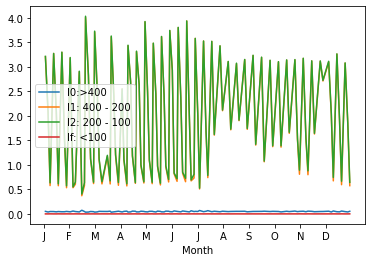

In [70]:
plt.plot(prof_l0.month,prof_l0.mean('PRES_INTERPOLATED'),label='l0:>{}'.format(l0))
plt.plot(prof_l1.month,prof_l1.mean('PRES_INTERPOLATED'),label='l1: {} - {}'.format(l0, l1))
plt.plot(prof_l2.month,prof_l2.mean('PRES_INTERPOLATED'),label='l2: {} - {}'.format(l1, l2))
plt.plot(prof_lf.month,prof_lf.mean('PRES_INTERPOLATED'),label='lf: <{}'.format(l2))
plt.xlabel('Month')
plt.xticks(range(1,13),month_labels)
plt.legend()

I think there are a few things to unpack here.
- First, it seems like <100m and >400m are not very helpful values to investigate seaonsal changes in spice because the vast majority of variance occurs between these two (maybe that's why things were weird for the Ratios method?)
    - On another examination, nothing really changes when I tried different filter scales, which seems to indicate that the problem isn't with the scales chosen, but something with the method itself
- Second, there seems to be some kind of monthly oscillation going on that I'm not entirely sure how to deal with. This isn't present in Steinberg Figure 5. Maybe I should run a .smothing() function and see if that helps? Or maybe this is an artifact of the method you used to calculate months?
- Speaking of, you should rewrite that method of converting to fractional month because you don't understand it well enough (just copied from StackOverflow).